In [40]:
#Importing necessary libraries
import pandas as pd 
from datetime import datetime 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator

In [2]:
#Read in the data
df = pd.read_csv("goldprice_1983-2022.csv")

In [3]:
#inspect the data frame

df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/1983,456.7,457.6,459.5,456.0,0.02K,0.0009
1,1/4/1983,460.0,460.0,460.5,456.0,0.03K,0.0072
2,1/5/1983,464.4,462.8,468.5,459.0,0.02K,0.0096
3,1/6/1983,459.7,462.0,463.5,458.0,0.04K,-0.0101
4,1/7/1983,472.7,472.7,475.0,466.5,0.05K,0.0283


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10162 entries, 0 to 10161
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      10162 non-null  object 
 1   Price     10162 non-null  float64
 2   Open      10162 non-null  float64
 3   High      10162 non-null  float64
 4   Low       10162 non-null  float64
 5   Vol.      8914 non-null   object 
 6   Change %  10162 non-null  float64
dtypes: float64(5), object(2)
memory usage: 555.9+ KB


In [5]:
#Standardize the column names. All in lower case

df.columns = [str.lower(x) for x in df.columns]

In [6]:
#Drop the unneccessary columns

df.drop(["open", "high", "low", "vol.", "change %"], axis = 1, inplace = True)

In [7]:
#Change the datetime column to datetime64[ns] type

df["date"] = pd.to_datetime(df["date"],format="%m/%d/%Y")

In [8]:
#Inspect the datafrme again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10162 entries, 0 to 10161
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    10162 non-null  datetime64[ns]
 1   price   10162 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 158.9 KB


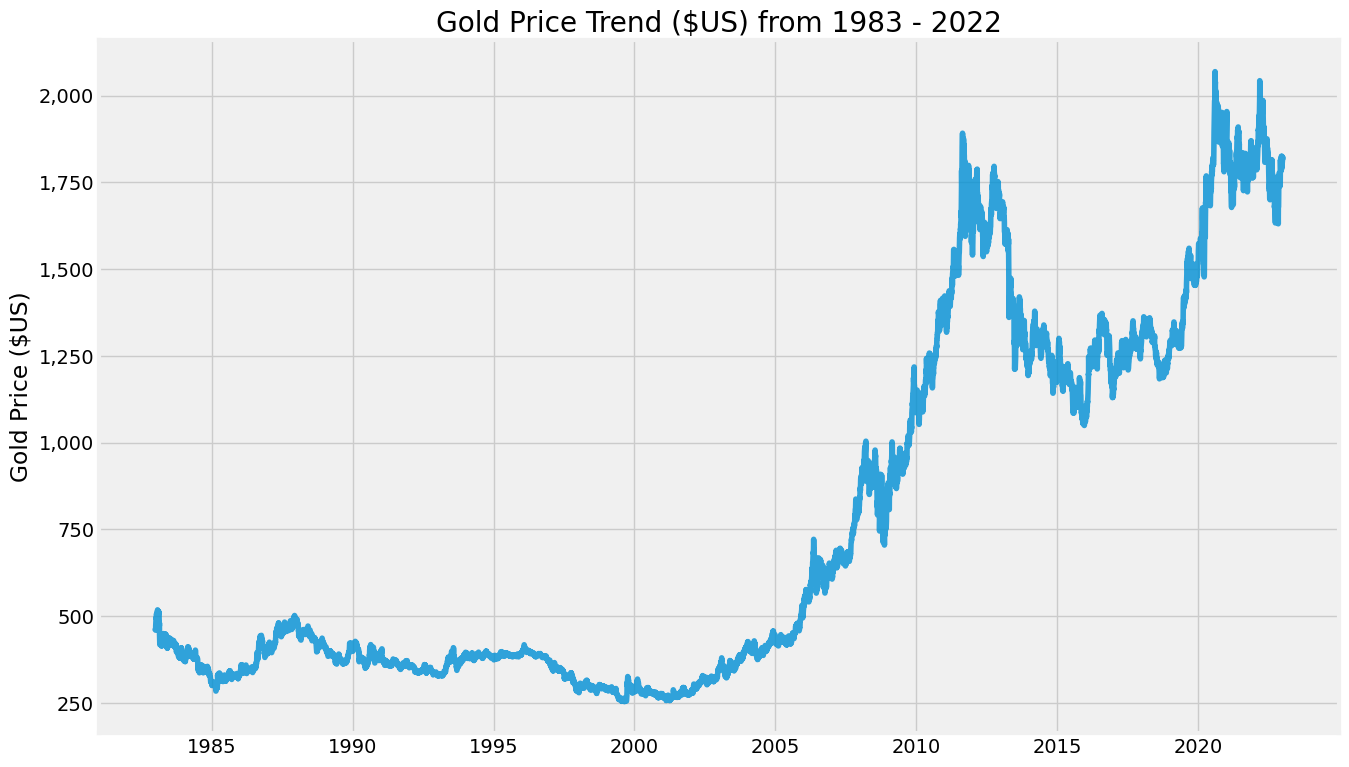

In [9]:
#Sorting the data in a chronological order from 1983 - 2022
df = df.sort_values(by="date",ascending=True)

# Custom formatting function with commas for thousand separators
def format_thousands_separator(value, _):
    formatted_value = "{:,.0f}".format(value)
    return formatted_value

#Gold price trend data visualization from 1983 - 2022
plt.figure(figsize=(16,9))
plt.style.use("fivethirtyeight")


#Plotting the price trend
plt.plot(df["date"], df["price"],label="gold price",alpha=0.8)
plt.title("Gold Price Trend ($US) from 1983 - 2022")
plt.ylabel("Gold Price ($US)")

# Apply the custom formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands_separator))

plt.show()

In [10]:
#Create the "year" column
df["year"] = df["date"].apply(lambda x: x.year)

In [11]:
#Create a function to get the day_month column:
def day_month(date):
    day = str(date.day)
    month = datetime.strftime(date, "%B")
    day_month = day+"-"+month
    return day_month

In [12]:
#Create a function to get the first day of year for each year:
def first_doy(df):
    first_doy_df = df.groupby("year")["date"].min().reset_index()
    first_doy_df.rename(columns={"date":"first_doy"},inplace=True)
    df = pd.merge(df,first_doy_df,on="year",how="left")
    return df


In [13]:
#Create a function to get the price on the first day of each year:
def price_first_doy(df):
    first_doy_price_df = df[df["date"]==df["first_doy"]][["first_doy","price"]]
    first_doy_price_df.rename(columns={"price":"first_doy_price"},inplace=True)
    df = pd.merge(df, first_doy_price_df, on="first_doy")
    return df

In [14]:
#Get the additional columns from the functions above
df["day_month"] = df["date"].apply(day_month)
df = first_doy(df)
df = price_first_doy(df)

In [15]:
df.head()

,date,price,year,day_month,first_doy,first_doy_price
0,1983-01-03,456.7,1983,3-January,1983-01-03,456.7
1,1983-01-04,460.0,1983,4-January,1983-01-03,456.7
2,1983-01-05,464.4,1983,5-January,1983-01-03,456.7
3,1983-01-06,459.7,1983,6-January,1983-01-03,456.7
4,1983-01-07,472.7,1983,7-January,1983-01-03,456.7


In [16]:
df["pct_diff_from_first_doy"] =  round(100*(df["price"] - df["first_doy_price"])/df["first_doy_price"],1)

In [17]:
df.head()

,date,price,year,day_month,first_doy,first_doy_price,pct_diff_from_first_doy
0,1983-01-03,456.7,1983,3-January,1983-01-03,456.7,0.0
1,1983-01-04,460.0,1983,4-January,1983-01-03,456.7,0.7
2,1983-01-05,464.4,1983,5-January,1983-01-03,456.7,1.7
3,1983-01-06,459.7,1983,6-January,1983-01-03,456.7,0.7
4,1983-01-07,472.7,1983,7-January,1983-01-03,456.7,3.5


In [18]:
#Count the number of positive and negative average % diff in each day of the year
df_prob = df.groupby('day_month')['pct_diff_from_first_doy'].apply(lambda x: pd.Series({"negative_pct_diff_counts":(x <= 0).sum(), "positive_pct_diff_counts":(x > 0).sum()})).reset_index()
df_prob = df_prob.pivot_table(index="day_month",columns="level_1",values="pct_diff_from_first_doy",aggfunc="sum")

In [19]:
#Find the min
df_min_max = df.groupby("day_month")["pct_diff_from_first_doy"].apply(lambda x: pd.Series({"min_pct_diff":x.min(), "max_pct_diff":x.max()})).reset_index()
df_min_max = df_min_max.pivot_table(index="day_month",columns="level_1",values="pct_diff_from_first_doy",aggfunc="sum")

In [20]:
#Merging profit prob and min, max

df=pd.merge(df,df_prob,on="day_month")
df=pd.merge(df,df_min_max, on="day_month")

In [21]:
#Calculate the % chance of making profit in each day group
df["profit_prob"] = round(100*df["positive_pct_diff_counts"]/(df["negative_pct_diff_counts"]+df["positive_pct_diff_counts"]),1)

In [23]:
df.head(10)

,date,price,year,day_month,first_doy,first_doy_price,pct_diff_from_first_doy,negative_pct_diff_counts,positive_pct_diff_counts,max_pct_diff,min_pct_diff,profit_prob
0,1983-01-03,456.7,1983,3-January,1983-01-03,456.7,0.0,20,8,1.6,-1.4,28.6
1,1984-01-03,384.9,1984,3-January,1984-01-03,384.9,0.0,20,8,1.6,-1.4,28.6
2,1985-01-03,305.2,1985,3-January,1985-01-02,306.2,-0.3,20,8,1.6,-1.4,28.6
3,1986-01-03,331.8,1986,3-January,1986-01-02,330.7,0.3,20,8,1.6,-1.4,28.6
4,1989-01-03,415.9,1989,3-January,1989-01-03,415.9,0.0,20,8,1.6,-1.4,28.6
5,1990-01-03,398.7,1990,3-January,1990-01-02,404.5,-1.4,20,8,1.6,-1.4,28.6
6,1991-01-03,390.3,1991,3-January,1991-01-02,392.6,-0.6,20,8,1.6,-1.4,28.6
7,1992-01-03,352.5,1992,3-January,1992-01-02,354.2,-0.5,20,8,1.6,-1.4,28.6
8,1994-01-03,395.6,1994,3-January,1994-01-03,395.6,0.0,20,8,1.6,-1.4,28.6
9,1995-01-03,382.9,1995,3-January,1995-01-03,382.9,0.0,20,8,1.6,-1.4,28.6


In [24]:
#Calculte for the mean of the % diff from the first doy of each day
mean_pct_diff_df = df[["day_month", "pct_diff_from_first_doy"]].groupby("day_month").mean().round(1).reset_index()
mean_pct_diff_df.rename(columns = {"pct_diff_from_first_doy":"mean_pct_diff"},inplace=True)

# #Calculte for the median of the % diff from the first doy of each day
# median_pct_diff_df = df[["day_month", "pct_diff_from_first_doy"]].groupby("day_month").median().reset_index()
# median_pct_diff_df.rename(columns = {"pct_diff_from_first_doy":"median_pct_diff"},inplace=True)

# #Create columns for the mean and median pct_diff:
# df_result = pd.merge(mean_pct_diff_df,median_pct_diff_df,on="day_month")

In [25]:
day_month_profit_prob_df = df[["day_month","min_pct_diff","max_pct_diff","profit_prob"]]

In [26]:
result_df = pd.merge(mean_pct_diff_df, day_month_profit_prob_df,on="day_month")

In [30]:
result_df.head(10)

,day_month,mean_pct_diff,min_pct_diff,max_pct_diff,profit_prob
0,1-April,1.4,-11.2,13.8,69.2
1,1-April,1.4,-11.2,13.8,69.2
2,1-April,1.4,-11.2,13.8,69.2
3,1-April,1.4,-11.2,13.8,69.2
4,1-April,1.4,-11.2,13.8,69.2
5,1-April,1.4,-11.2,13.8,69.2
6,1-April,1.4,-11.2,13.8,69.2
7,1-April,1.4,-11.2,13.8,69.2
8,1-April,1.4,-11.2,13.8,69.2
9,1-April,1.4,-11.2,13.8,69.2


In [32]:
result_df = result_df.drop_duplicates()

In [33]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 0 to 10133
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day_month      364 non-null    object 
 1   mean_pct_diff  364 non-null    float64
 2   min_pct_diff   364 non-null    float64
 3   max_pct_diff   364 non-null    float64
 4   profit_prob    364 non-null    float64
dtypes: float64(4), object(1)
memory usage: 17.1+ KB


In [34]:
month_order_dict = {"months": ['January','February','March','April','May','June','July','August','September','October','November','December'],
                     "month_order":[1,2,3,4,5,6,7,8,9,10,11,12]}

month_order_df = pd.DataFrame(month_order_dict)

In [35]:
result_df[["day_order","months"]] = result_df["day_month"].str.split("-",expand=True)
result_df["day_order"] = result_df["day_order"].astype(int)

result_df = pd.merge(result_df,month_order_df,on="months")

In [36]:
result_df.sort_values(["month_order","day_order"],ascending=True,inplace=True)
result_df.reset_index(drop=True,inplace=True)
result_df

,day_month,mean_pct_diff,min_pct_diff,max_pct_diff,profit_prob,day_order,months,month_order
0,2-January,0.0,0.0,0.0,0.0,2,January,1
1,3-January,0.0,-1.4,1.6,28.6,3,January,1
2,4-January,-0.3,-3.1,1.1,34.5,4,January,1
3,5-January,-0.2,-4.9,1.7,46.4,5,January,1
4,6-January,-0.2,-3.6,2.8,48.3,6,January,1
...,...,...,...,...,...,...,...,...
359,27-December,3.1,-28.1,30.4,58.6,27,December,12
360,28-December,5.0,-18.9,32.1,58.6,28,December,12
361,29-December,5.2,-20.4,26.4,60.7,29,December,12
362,30-December,4.5,-28.7,25.7,58.6,30,December,12


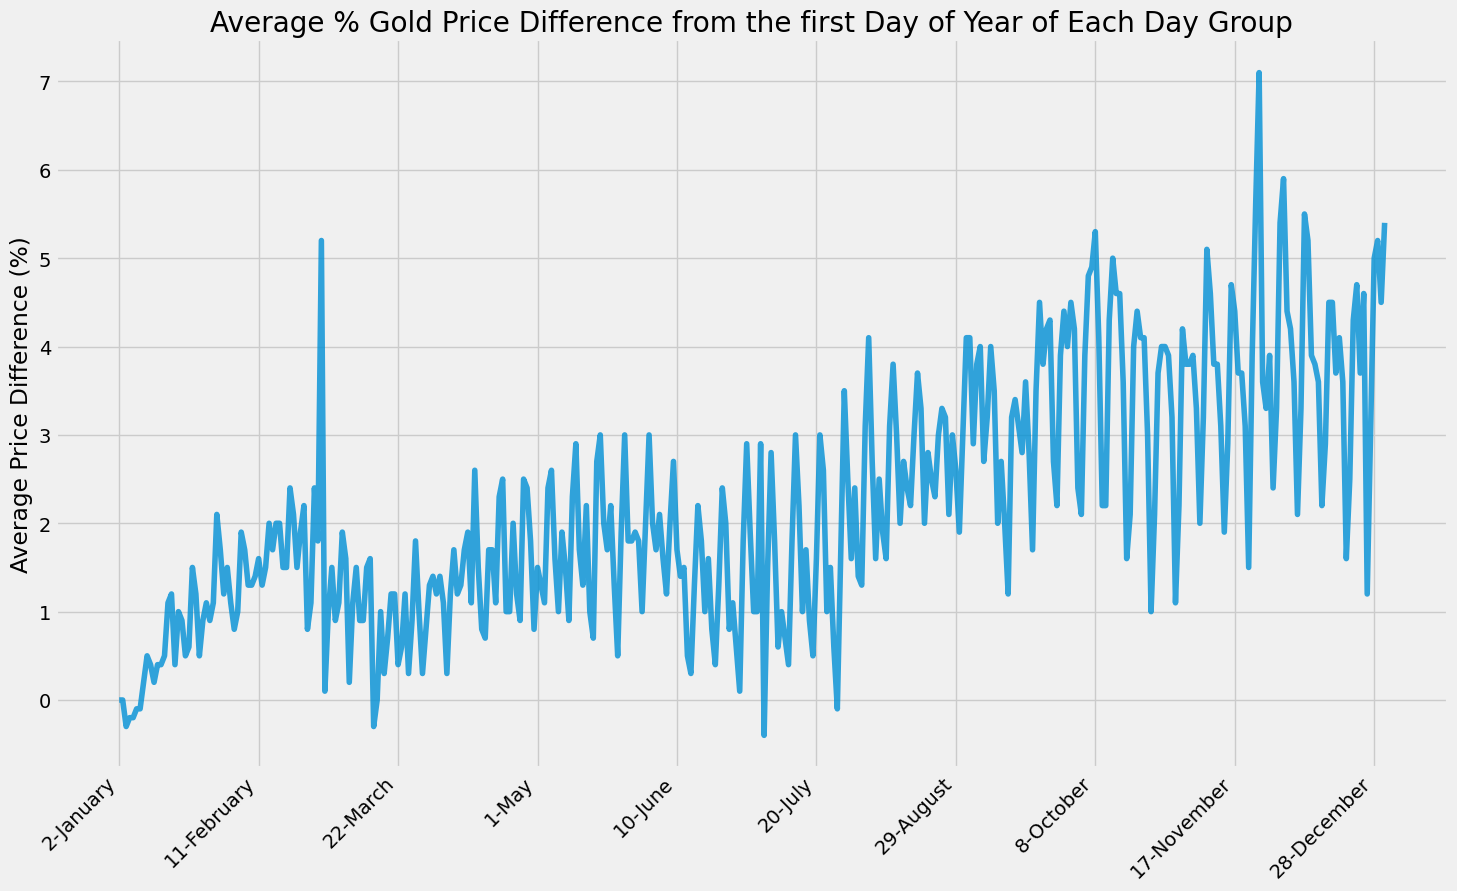

In [47]:
plt.figure(figsize=(16,9))
plt.style.use("fivethirtyeight")
plt.plot(result_df["day_month"], result_df["mean_pct_diff"],alpha=0.8)
plt.title("Average % Gold Price Difference from the first Day of Year of Each Day Group")
plt.ylabel("Average Price Difference (%)")
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10)) 
plt.xticks(rotation=45,ha="right")
plt.show()

In [48]:
result_df.sort_values("mean_pct_diff",ascending=False)[0:10]

,day_month,mean_pct_diff,min_pct_diff,max_pct_diff,profit_prob,day_order,months,month_order
327,24-November,7.1,-17.2,32.6,68.2,24,November,11
334,1-December,5.9,-19.6,36.5,64.3,1,December,12
326,23-November,5.6,-17.1,32.4,58.3,23,November,11
340,7-December,5.5,-14.1,32.3,55.2,7,December,12
333,30-November,5.4,-13.4,34.4,62.1,30,November,11
363,31-December,5.4,-28.8,31.3,53.8,31,December,12
280,8-October,5.3,-21.6,33.8,57.1,8,October,10
341,8-December,5.2,-21.1,30.0,60.7,8,December,12
361,29-December,5.2,-20.4,26.4,60.7,29,December,12
58,29-February,5.2,-9.8,14.8,85.7,29,February,2
